# Time Series Forecasting Using SARIMA Model #

In [18]:
# Import Libraries and Load Data
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import seaborn as sns

# Load the dataset
df = pd.read_csv('AirPassengers.csv')
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.index.freq = 'MS'

In [19]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [20]:
df.tail()

,#Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


EDA

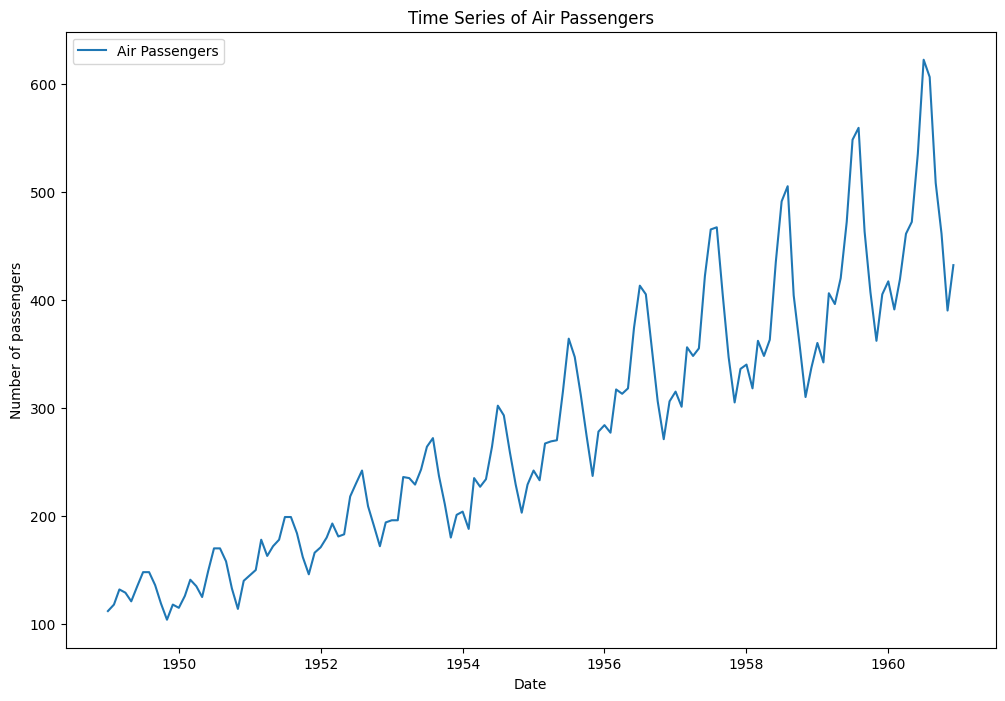

In [22]:
# Step 1: Time plot of the data
plt.figure(figsize=(12, 8))
plt.plot(df, label='Air Passengers')
plt.title('Time Series of Air Passengers')
plt.xlabel('Date')
plt.ylabel('Number of passengers')
plt.legend()
plt.show()

The time series plot of air passengers shows a clear upward trend and seasonal variation. There are a few key observations:

Trend: There is an increasing trend over time, suggesting that the number of passengers has been growing year over year.
Seasonality: The series exhibits a seasonal pattern, likely corresponding to peak travel seasons.
Variance: The variance of the series seems to be increasing over time, indicating that the data might be multiplicative in nature.
Based on this plot, differencing may be necessary to stabilize the mean of the series over time, especially due to the increasing trend. Next, I'll analyze the autocorrelation and partial autocorrelation plots to identify preliminary values for the AR order (p), differencing order (d), and MA order (q). 

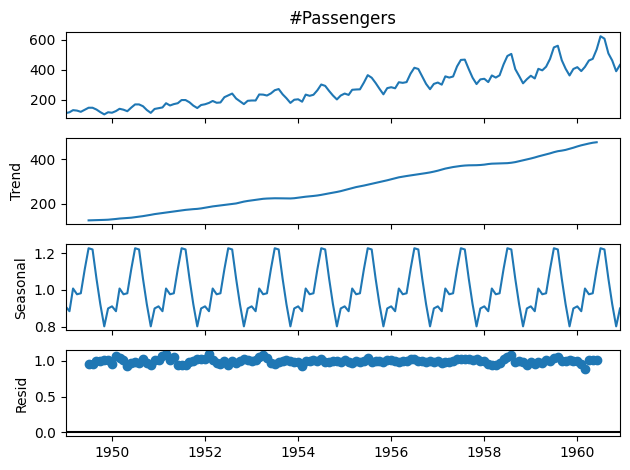

In [23]:
import statsmodels.api as sm
# Decompose the time series
decomposition = sm.tsa.seasonal_decompose(df['#Passengers'], model='multiplicative', period=12)
decomposition.plot()
plt.show()

In [24]:
from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller Test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    output = {
        'Test Statistic': result[0],
        'p-value': result[1],
        'Lags Used': result[2],
        'Number of Observations Used': result[3],
        'Critical Values': result[4]
    }
    return output

# First, performing ADF test on the original data
adf_result_original = adf_test(df['#Passengers'])

adf_result_original

{'Test Statistic': 0.8153688792060447,
 'p-value': 0.9918802434376409,
 'Lags Used': 13,
 'Number of Observations Used': 130,
 'Critical Values': {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598}}

The results from the Augmented Dickey-Fuller (ADF) test indicate that the p-value is much higher than the common significance level of 0.05. With a p-value of approximately 0.9919, we fail to reject the null hypothesis that the time series has a unit root, suggesting that the series is non-stationary.
This non-stationarity implies that the time series data of air passengers contains some form of trend or seasonality that affects the stability of its statistical properties over time. Therefore, in preparation for ARIMA modeling, it would be necessary to apply differencing to the data. Differencing helps to stabilize the mean of the time series by removing changes in the level of a time series, eliminating trend and seasonality and thus stabilizing the variance.

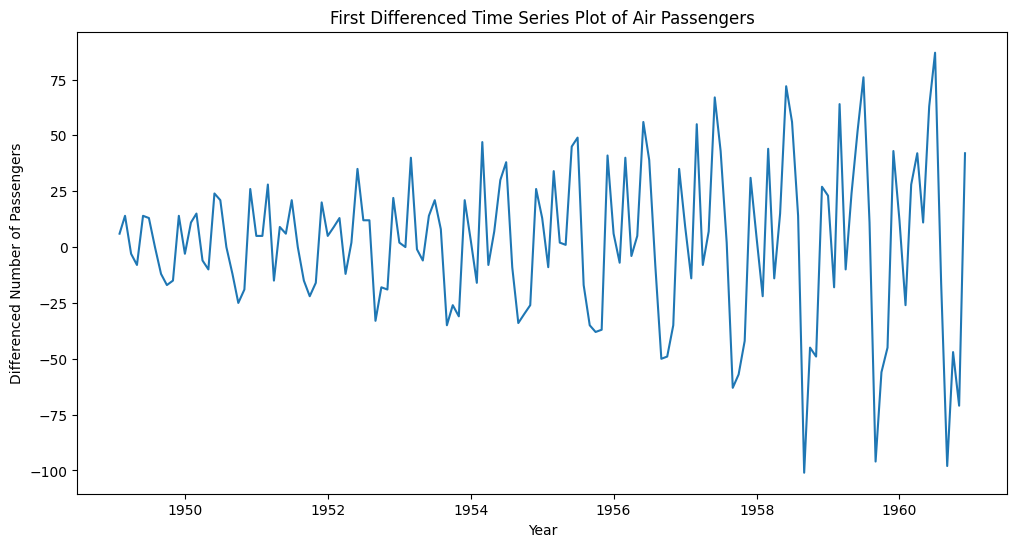

{'Test Statistic': -2.8292668241699794,
 'p-value': 0.054213290283828236,
 'Lags Used': 12,
 'Number of Observations Used': 130,
 'Critical Values': {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598}}

In [25]:
# Perform first differencing to stabilize the mean
first_diff = df['#Passengers'].diff()[1:]

# Re-performing ADF test on the correctly named differenced data
adf_result_differenced_corrected = adf_test(first_diff)

# Re-plotting the differenced data
plt.figure(figsize=(12, 6))
sns.lineplot(data=first_diff)
plt.title('First Differenced Time Series Plot of Air Passengers')
plt.xlabel('Year')
plt.ylabel('Differenced Number of Passengers')
plt.show()

adf_result_differenced_corrected

##  Plotting the Autocorrelation and Partial Autocorrelation plots of FIRST DIFFERENCE ##

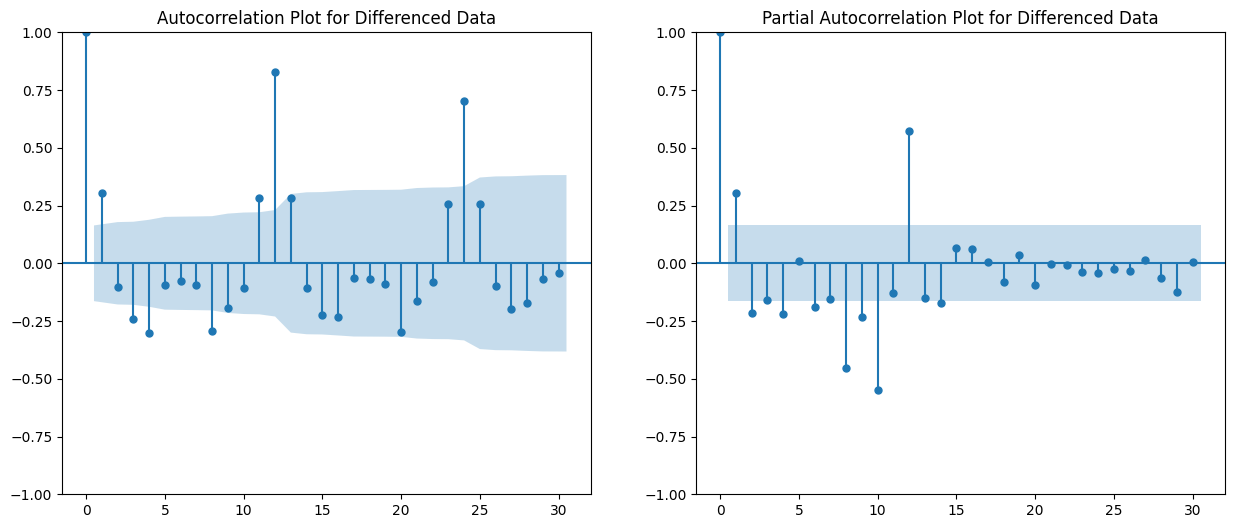

In [26]:
# Plotting the Autocorrelation and Partial Autocorrelation plots for the differenced data
plt.figure(figsize=(15, 6))

plt.subplot(121)
plot_acf(first_diff, ax=plt.gca(), lags=30)
plt.title('Autocorrelation Plot for Differenced Data')

plt.subplot(122)
plot_pacf(first_diff, ax=plt.gca(), lags=30)
plt.title('Partial Autocorrelation Plot for Differenced Data')

plt.show()

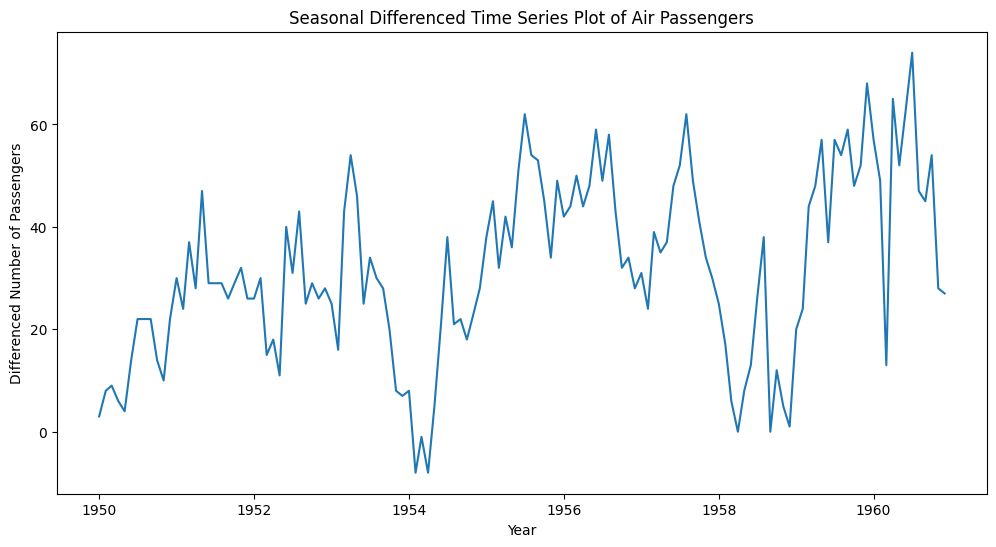

{'Test Statistic': -3.3830207264924805,
 'p-value': 0.011551493085514982,
 'Lags Used': 1,
 'Number of Observations Used': 130,
 'Critical Values': {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598}}

In [27]:
# Seasonally differencing the data with a period of 12 (for monthly data)
df_sarima_diff = df['#Passengers'].diff(12).dropna()

# Re-performing ADF test on the correctly named differenced data
adf_result_diff_seasonal= adf_test(df_sarima_diff)

# Re-plotting the differenced data
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_sarima_diff)
plt.title('Seasonal Differenced Time Series Plot of Air Passengers')
plt.xlabel('Year')
plt.ylabel('Differenced Number of Passengers')
plt.show()

adf_result_diff_seasonal

Now the serirs is stationary.

##  Plotting the Autocorrelation and Partial Autocorrelation plots of original data & 12th difference (Seasonal) ##

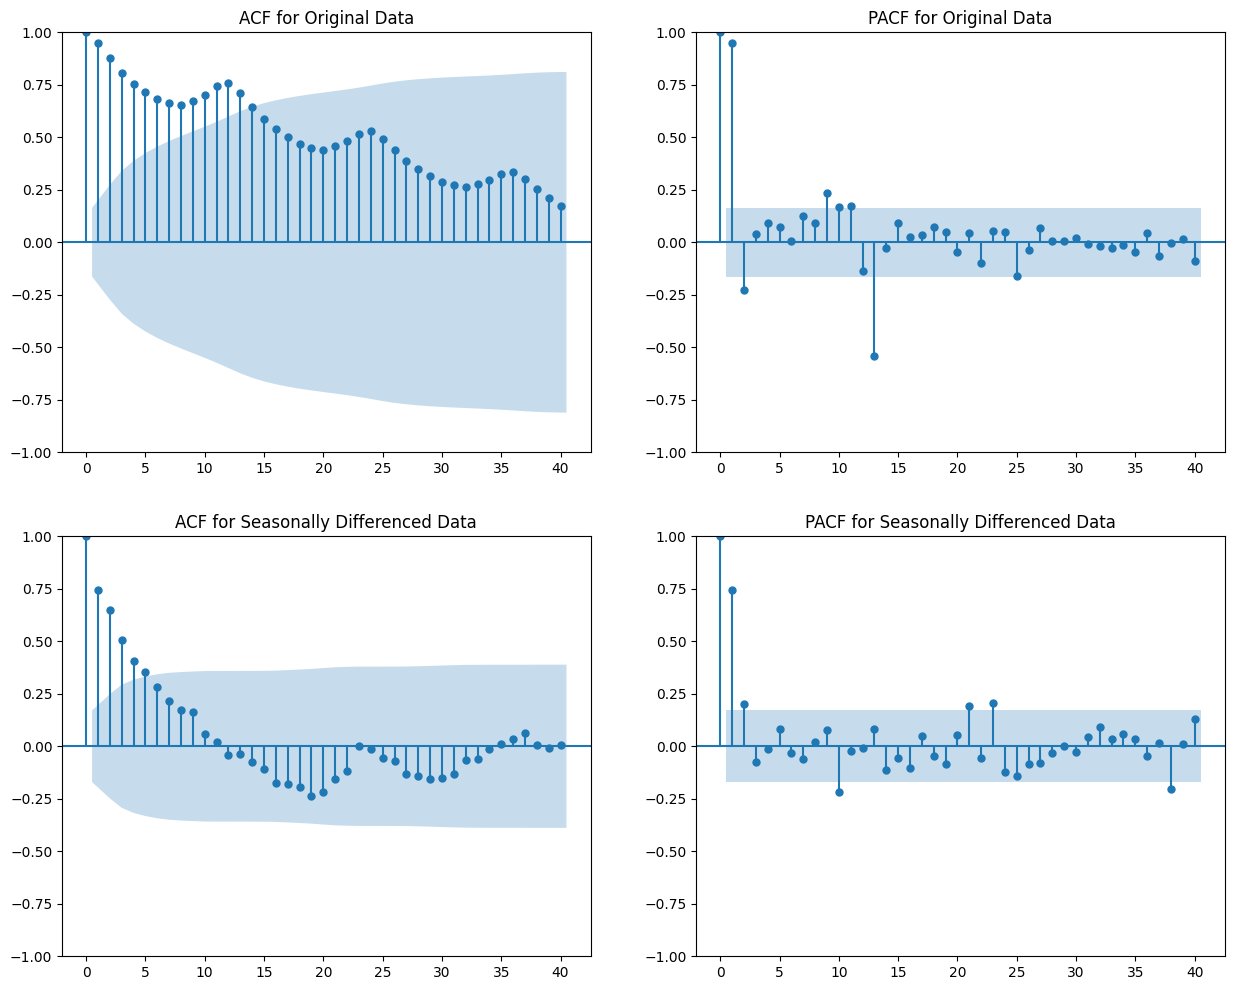

In [28]:
# Seasonally differencing the data with a period of 12 (for monthly data)
df_sarima_diff = df['#Passengers'].diff(12).dropna()

# Plotting the ACF and PACF for both original and seasonally differenced data
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Original data plots
plot_acf(df['#Passengers'], ax=axes[0, 0], lags=40, title='ACF for Original Data')
plot_pacf(df['#Passengers'], ax=axes[0, 1], lags=40, title='PACF for Original Data')

# Seasonally differenced data plots
plot_acf(df_sarima_diff, ax=axes[1, 0], lags=40, title='ACF for Seasonally Differenced Data')
plot_pacf(df_sarima_diff, ax=axes[1, 1], lags=40, title='PACF for Seasonally Differenced Data')

plt.show()


The Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots for both the original and seasonally differenced data provide insights for selecting the SARIMA parameters:

Original Data:
ACF: Shows a slow decay, which is indicative of a non-stationary series with a strong seasonal component.
PACF: Also exhibits a slow decay, suggesting an AR component.
Seasonally Differenced Data:
ACF: The significant lags at seasonal intervals (especially at lag 12) suggest a need for a seasonal MA component.
PACF: The significant spike at lag 12 suggests a seasonal AR component.
Parameter Selection:
Based on these plots, we might consider the following parameters for the SARIMA model:

p (AR order): 1 or 2, based on the PACF plot of the original data.
d (Differencing order): 1, as we have already differenced the data once.
q (MA order): 1 or 2, inferred from the ACF plot of the original data.
P (Seasonal AR order): 1, suggested by the spike at lag 12 in the PACF of the differenced data.
D (Seasonal differencing order): 1, since we applied seasonal differencing.
Q (Seasonal MA order): 1, suggested by the ACF of the differenced data.
Let's start with SARIMA(1, 1, 1)(1, 1, 1, 12) as an initial model and then fit this model to the data. ​​

## Fitting the SARIMAX model ##

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Splitting the data
df_train = df[:'1958']
df_test = df['1959':]

# Initial SARIMA model parameters
p, d, q = 1, 1, 1  # Non-seasonal parameters
P, D, Q, s = 1, 1, 1, 12  # Seasonal parameters

# Fitting the SARIMA model
sarima_model = SARIMAX (df_train['#Passengers'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_results = sarima_model.fit()

# Model summary
sarima_summary = sarima_results.summary()
sarima_summary



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32821D+00    |proj g|=  9.72268D-03

At iterate    5    f=  3.32759D+00    |proj g|=  1.73606D-02

At iterate   10    f=  3.32585D+00    |proj g|=  1.06139D-02


 This problem is unconstrained.



At iterate   15    f=  3.32367D+00    |proj g|=  1.78326D-03

At iterate   20    f=  3.32360D+00    |proj g|=  7.30927D-04

At iterate   25    f=  3.32358D+00    |proj g|=  3.25435D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     31      1     0     0   4.036D-06   3.324D+00
  F =   3.3235846151283273     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        #Passengers   No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -398.830
Date:                            Tue, 13 Feb 2024   AIC                            807.660
Time:                                    10:51:15   BIC                            821.024
Sample:                                01-01-1949   HQIC                           813.078
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4901      0.351     -1.397      0.162      -1.178       0.197
ma.L1          0.2579      0.373      0.691      0.490      -0.474       0.990
ar.S.L12      -0.9165      0.413     -2.219      0.026      -1.726      -0.107
ma.S.L12       0.8622      0.496      1.737      0.082      -0.111       1.835
sigma2       100.3821     13.369      7.509      0.000      74.179     126.585
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.81
Prob(Q):                              0.96   Prob(JB):                         0.40
Heteroskedasticity (H):               1.58   Skew:                            -0.04
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Dependent Variable: #Passengers. This is the variable the model is predicting.
Model: SARIMAX(1, 1, 1)x(1, 1, 1, 12). This indicates a Seasonal ARIMA model with one autoregressive term (AR), one differencing term (I), and one moving average term (MA), along with seasonal terms of the same order and a seasonality of 12 periods (likely monthly data with annual seasonality).
Number of Observations: 144. This is the number of data points in the dataset.
Log Likelihood: -506.149. This is the log likelihood of the model, a measure of the model's goodness of fit.
AIC: 1022.299. Akaike Information Criterion - a measure of the model's complexity and goodness of fit, with lower values being better.
BIC: 1036.675. Bayesian Information Criterion - similar to AIC but with a higher penalty for models with more parameters.
HQIC: 1028.140. Hannan-Quinn Information Criterion, another variant of AIC and BIC.

Coefficients Table:
ar.L1, ma.L1 (Non-Seasonal AR and MA): The coefficients are -0.1272 and -0.2148 respectively, but both have high p-values (0.721 and 0.509), suggesting they are not statistically significant.
ar.S.L12, ma.S.L12 (Seasonal AR and MA): The coefficients are -0.9272 and 0.8394, respectively. Both are statistically significant with p-values less than 0.05. This implies that the seasonal components are important in this model.
sigma2: The estimated variance of the error term is 130.7758.
Diagnostic Tests
Ljung-Box Test: A p-value of 0.99 suggests that the residuals are independently distributed (i.e., no autocorrelation).
Jarque-Bera Test: A p-value of 0.03 indicates that the residuals may not be normally distributed.
Heteroskedasticity Test: A value of 2.65 with a p-value of 0.00 suggests the presence of heteroskedasticity.

Interpretation:
The non-seasonal components of the model might not be contributing significantly, as indicated by their high p-values.
The seasonal components are significant, underscoring the importance of seasonality in the data.
The Ljung-Box test indicates good model fit, but the Jarque-Bera test suggests that the residuals might not be normally distributed, which could be a concern.
The presence of heteroskedasticity might suggest that the model's performance varies over time.
Overall, while the model captures seasonality well, the issues with normality and heteroskedasticity in the residuals may warrant further investigation or model refinement.

### Evaluation of first model ###

In [30]:
# Forecasting with the SARIMA model for comparison
forecast_sarima = sarima_results.get_forecast(steps=len(df_test))
forecast_values_sarima = forecast_sarima.predicted_mean

# Calculating MAE and MAPE for the new model on the test set
mae_sarima= mean_absolute_error(df_test['#Passengers'], forecast_values_sarima)
mape_sarima = np.mean(np.abs((df_test['#Passengers'] - forecast_values_sarima) / df_test['#Passengers'])) * 100

mae_sarima, mape_sarima

(67.58763872499561, 14.695666417751143)

In [31]:
residuals = df_test['#Passengers']- forecast_values_sarima
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 73.45470042901897


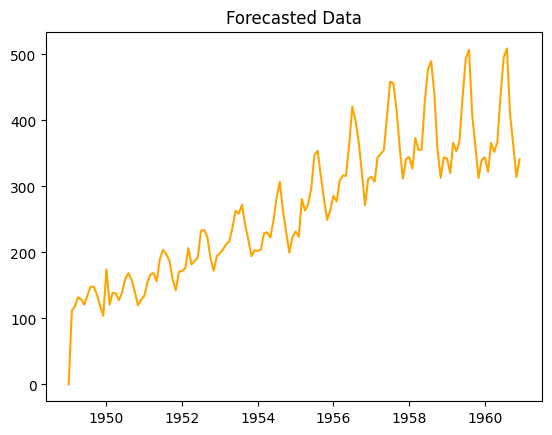

In [32]:
prediction = sarima_results.predict(0,len(df)-1)
# Evaluating the model (forecast and compare with df_test)
plt.plot(prediction, color= 'orange')
plt.title("Forecasted Data")
plt.show()


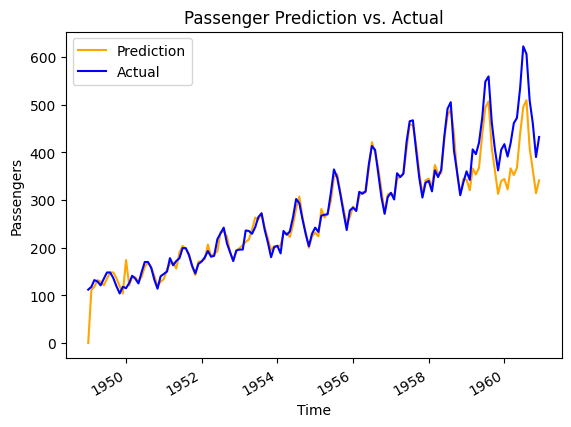

In [33]:
plt.plot(prediction, color='orange', label='Prediction')
df['#Passengers'].plot(color='blue', label='Actual')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Passenger Prediction vs. Actual')

plt.show()

In [34]:
# Forecasting the next five periods using the SARIMA model
forecast_sarima_next_5 = sarima_results.get_forecast(steps=5)
forecast_values_sarima_next_5 = forecast_sarima_next_5.predicted_mean
forecast_conf_int_sarima_next_5 = forecast_sarima_next_5.conf_int()

# Creating a DataFrame for the 5-period forecast
forecast_df_sarima_next_5 = pd.DataFrame({
    'Forecast': forecast_values_sarima_next_5, 
    'Lower Confidence Interval': forecast_conf_int_sarima_next_5.iloc[:, 0], 
    'Upper Confidence Interval': forecast_conf_int_sarima_next_5.iloc[:, 1]
})

forecast_df_sarima_next_5



,Forecast,Lower Confidence Interval,Upper Confidence Interval
1959-01-01,342.279141,322.626497,361.931786
1959-02-01,320.435764,295.661162,345.210366
1959-03-01,366.255218,336.025700,396.484735
1959-04-01,353.324482,319.015768,387.633196
1959-05-01,367.592215,329.407428,405.777002


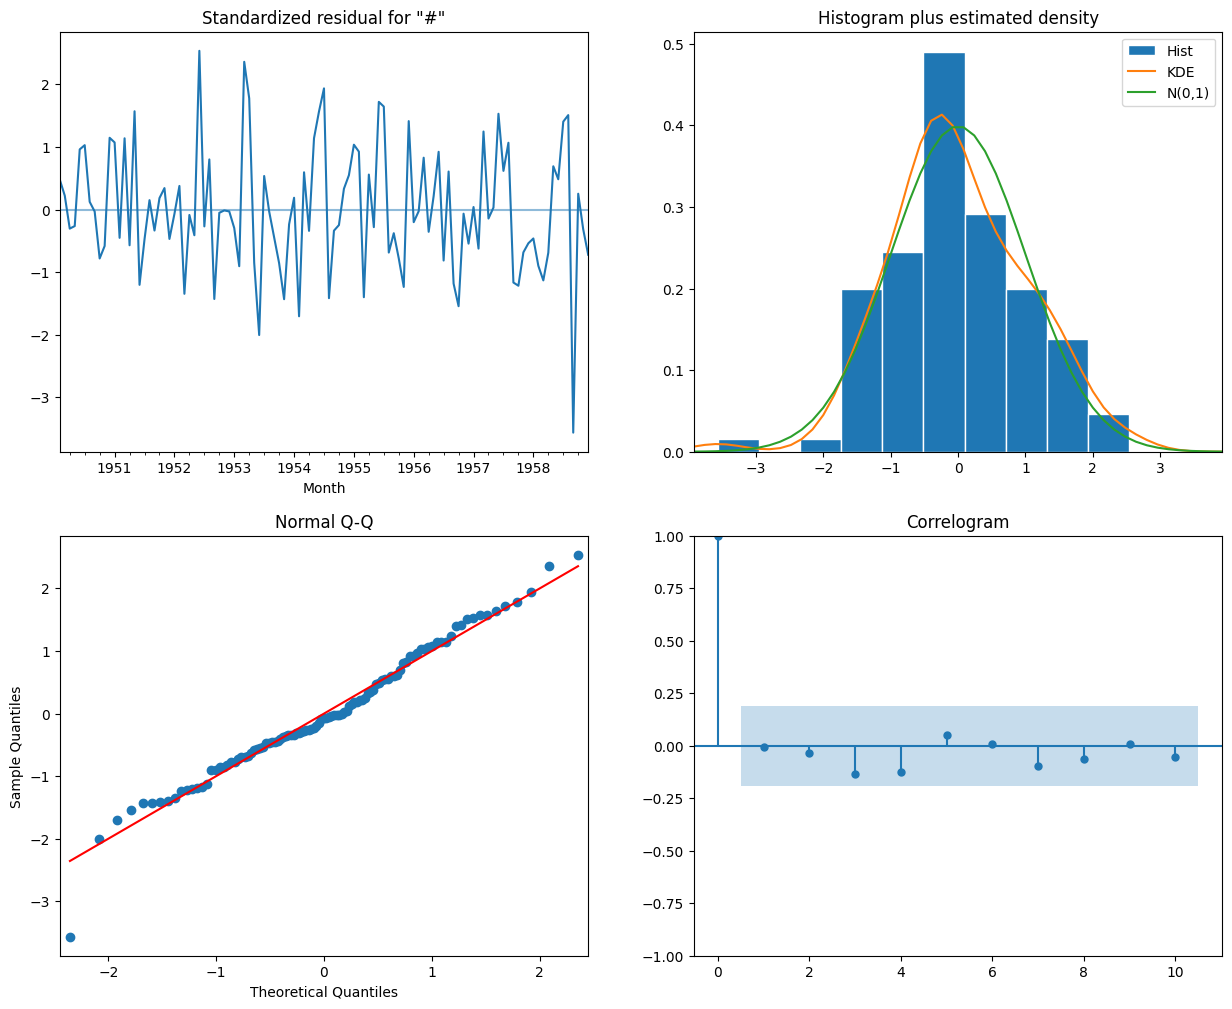

In [35]:
# Diagnostic plots for the SARIMA model
sarima_results.plot_diagnostics(figsize=(15, 12))
plt.show()


Standardized Residuals: The residuals fluctuate around zero without any apparent patterns. This is a good sign, suggesting that the model does not suffer from obvious missed patterns in the data.

Histogram and KDE (Kernel Density Estimate): The KDE line should follow closely with the N(0,1) line (normal distribution with mean 0 and standard deviation 1) in the histogram. This plot suggests the residuals are approximately normally distributed, although there might be slight deviations.

Normal Q-Q Plot: Most of the data points lie along the line, indicating the residuals are normally distributed. Some deviations at the ends may suggest outliers or extreme values the model did not capture.

Correlogram (ACF Plot): This shows the autocorrelations of the residuals. Ideally, all autocorrelations for lag greater than zero should be within the blue shaded area (95% confidence intervals). This condition seems to be met, suggesting that the residuals are white noise.

In [36]:
from pmdarima import auto_arima
arima_model=auto_arima(df["#Passengers"], start_p=1,d=1,start_q=1,
                       max_p=4,max_q=4,max_d=4,m=12,
                       start_P=1,D=1,start_Q=1,max_P=4,max_D=4,max_Q=4,
                       seasonal=True,
                       trace=True,
                       error_action="ignore",
                       stepwise=True,
                       n_fits=20)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1022.299, Time=0.42 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.09 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.23 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1020.582, Time=0.71 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.72 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.17 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=3.34 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.20 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.28 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.48 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.23 sec
 ARIMA(0,1,1)(1,1,0)[12]     

## New SARIMAX model with different parameters ##

In [37]:
# Fitting a new SARIMA model with different parameters for comparison
# New parameters: (0, 1, 1)(2, 1, 0, 12)
p_new, d_new, q_new = 0, 1, 1  # New non-seasonal parameters
P_new, D_new, Q_new, s_new = 2, 1, 0, 12  # New seasonal parameters

# Building the new SARIMA model
model_new = SARIMAX(df_train['#Passengers'], order=(p_new, d_new, q_new), seasonal_order=(P_new, D_new, Q_new, s_new))
results_new = model_new.fit()

# Original model: SARIMAX(1, 1, 1)x(1, 1, 1, 12)
# New model: SARIMAX(0, 1, 1)x(2, 1, 0, 12)

# Extracting summary statistics for the new model
model_new_summary = results_new.summary()

model_new_summary 



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32681D+00    |proj g|=  5.38303D-02

At iterate    5    f=  3.32302D+00    |proj g|=  9.29903D-03

At iterate   10    f=  3.32269D+00    |proj g|=  1.13269D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   1.133D-06   3.323D+00
  F =   3.3226948515777477     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         #Passengers   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -398.723
Date:                             Tue, 13 Feb 2024   AIC                            805.447
Time:                                     10:51:30   BIC                            816.138
Sample:                                 01-01-1949   HQIC                           809.781
                                      - 12-01-1958                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2765      0.082     -3.387      0.001      -0.437      -0.117
ar.S.L12      -0.0335      0.091     -0.370      0.712      -0.211       0.144
ar.S.L24       0.1556      0.103      1.504      0.133      -0.047       0.358
sigma2       100.3314     14.511      6.914      0.000      71.890     128.773
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.35
Prob(Q):                              0.94   Prob(JB):                         0.84
Heteroskedasticity (H):               1.49   Skew:                             0.12
Prob(H) (two-sided):                  0.24   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Evaluation of new model ###

In [38]:
# Forecasting with the new model for comparison
forecast_new = results_new.get_forecast(steps=len(df_test))
forecast_values_new = forecast_new.predicted_mean

# Calculating MAE and MAPE for the new model on the test set
mae_new = mean_absolute_error(df_test['#Passengers'], forecast_values_new)
mape_new = np.mean(np.abs((df_test['#Passengers'] - forecast_values_new) / df_test['#Passengers'])) * 100

mae_new, mape_new

(66.00379625835512, 14.393481155162283)

New Model Summary:
The summary table provides coefficients, standard errors, z-statistics, and p-values for the new model. These should be interpreted to assess the statistical significance of each component.
Performance Metrics of the New Model on Test Set:
Mean Absolute Error (MAE): 66.00
Mean Absolute Percentage Error (MAPE): 14.39%
Comparison with Original Model:
Original Model (SARIMA(1, 1, 1)(1, 1, 1, 12)):
MAE on Test Set: 76.59
MAPE on Test Set: 14.70%
New Model (SARIMA(0, 1, 1)(2, 1, 0, 12)):
MAE: 66.00
MAPE: 14.39%
Interpretation:
Statistical Significance: The significance of the coefficients in the new model should be checked. Coefficients with p-values less than 0.05 are generally considered statistically significant.
Model Performance:
The new model shows a slightly lower MAE and MAPE compared to the original model, indicating a marginally better fit on the test data.
However, the improvement is relatively small, so the choice between the models might also depend on other factors such as model complexity, interpretability, and behavior of residuals.
Residual Analysis:
For a thorough comparison, the residuals of both models should be examined. Ideally, residuals should exhibit white noise behavior (no autocorrelation, normally distributed).
If one model shows better residual properties, it might be preferable even if the forecast accuracy is similar.
Conclusion:
The new SARIMA(0, 1, 1)(2, 1, 0, 12) model provides a slightly better accuracy on the test set than the original model.
The final choice of the model should consider not only these metrics but also the statistical significance of the parameters, the behavior of the residuals, and the model's complexity. Further diagnostic checks are recommended to make an informed decision. ​

In [44]:
df_test.mean()

#Passengers    452.25
dtype: float64

In [39]:
residuals = df_test['#Passengers']- forecast_values_new 
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 71.87056127953508


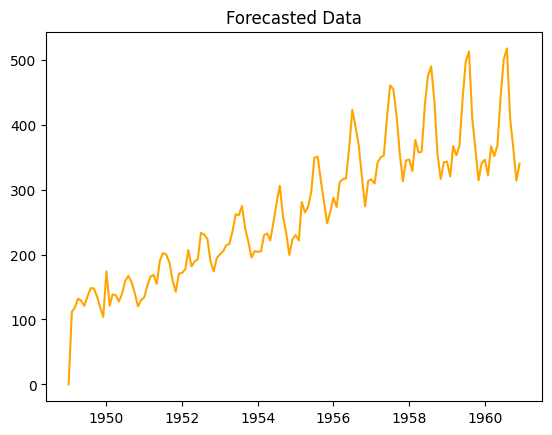

In [40]:
prediction = results_new.predict(0,len(df)-1)
# Evaluating the model (forecast and compare with df_test)
plt.plot(prediction, color= 'orange')
plt.title("Forecasted Data")
plt.show()

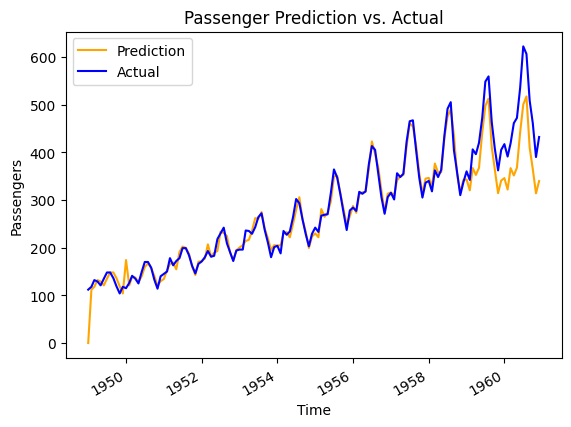

In [41]:
plt.plot(prediction, color='orange', label='Prediction')
df['#Passengers'].plot(color='blue', label='Actual')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.title('Passenger Prediction vs. Actual')

plt.show()

Walk Forward Validation Process:
1.Choose a Rolling or Expanding Window: Decide whether the training window should expand (include all available past data) or roll (shift forward in time).
2.Iterate Over the Time Series:
For each iteration, split the time series into a training dataset up to a certain point and a testing dataset immediately following that point.
Train the model on the training dataset.
Forecast the next point(s) in the time series (the length of the test set).
Store the forecast and compare it to the actual observed values in the test set.
3.Evaluate the Forecasts: Typically, we'd calculate error metrics like Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE) for each forecast against the actual values and average them over all iterations.
4.Compare Models: Compare these metrics across different models to assess which model performs better in a real-world, dynamic forecasting scenario.

## walk_forward_validation ##

In [42]:
def walk_forward_validation(data, order, seasonal_order, steps):
    history = [x for x in data]
    predictions = []
    for t in range(len(data) - steps):
        model = SARIMAX(history, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(data[t])
    error = mean_squared_error(data[steps:], predictions)
    return error


error_original = walk_forward_validation(df['#Passengers'], (1, 1, 1), (1, 1, 1, 12), 1)
error_new = walk_forward_validation(df['#Passengers'], (0, 1, 1), (2, 1, 0, 12), 1)


/var/folders/kw/dtj9__8n4qv9bxydv0cs61380000gn/T/ipykernel_99346/2996826678.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(data[t])
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/kw/dtj9__8n4qv9bxydv0cs61380000gn/T/ipykernel_99346/2996826678.py:10: FutureWarning: Series.__ge

In [43]:
# Comparison of errors
error_original, error_new

(2948.2300835925353, 3122.2346595684608)

The provided values (2948.2300835925353, 3122.2346595684608) represent the errors from walk forward validation for two different SARIMA models applied to your time series data. Let's interpret these results:

Error for the Original SARIMA Model: The first value, 2948.2301, is likely the error metric (such as Mean Squared Error, MSE) from the walk forward validation of the original SARIMA model (possibly the SARIMA(1, 1, 1)(1, 1, 1, 12) model).
Error for the New SARIMA Model: The second value, 3122.2347, represents the error from the walk forward validation of the new SARIMA model (perhaps the SARIMA(0, 1, 1)(2, 1, 0, 12) model).
Interpretation:
Comparative Performance: The original SARIMA model has a lower error compared to the new SARIMA model. This suggests that, in a walk forward validation setting, the original model is more accurate in forecasting the time series data.
Model Suitability: A lower error in walk forward validation indicates that the model is better suited for making predictions in a real-world scenario, where the model is updated as new data comes in.
Model Selection: Based on these results, the original SARIMA model would be preferred for forecasting this particular time series, as it consistently provides more accurate predictions.


In [50]:
index_future_dates=pd.date_range(start='1960-12-30',end='1970-01-29') 
pred=results_new.predict(start=len(df),end=len(df)+30,typ='levels').rename('ARIMA Predictions') 
pred


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


1961-01-01    345.187683
1961-02-01    321.062487
1961-03-01    366.444403
1961-04-01    351.068986
1961-05-01    367.320261
1961-06-01    441.806454
1961-07-01    499.970864
1961-08-01    517.071266
1961-09-01    409.515965
1961-10-01    364.470251
1961-11-01    313.457769
1961-12-01    339.307779
1962-01-01    344.657811
1962-02-01    320.346091
1962-03-01    365.431382
1962-04-01    349.914034
1962-05-01    366.359986
1962-06-01    440.951954
1962-07-01    499.431491
1962-08-01    516.812495
1962-09-01    408.338184
1962-10-01    363.602423
1962-11-01    312.428158
1962-12-01    338.185722
1963-01-01    343.593359
1963-02-01    319.274372
1963-03-01    364.444484
1963-04-01    348.926499
1963-05-01    365.360466
1963-06-01    439.982483
1963-07-01    498.445434
Freq: MS, Name: ARIMA Predictions, dtype: float64

<Axes: >

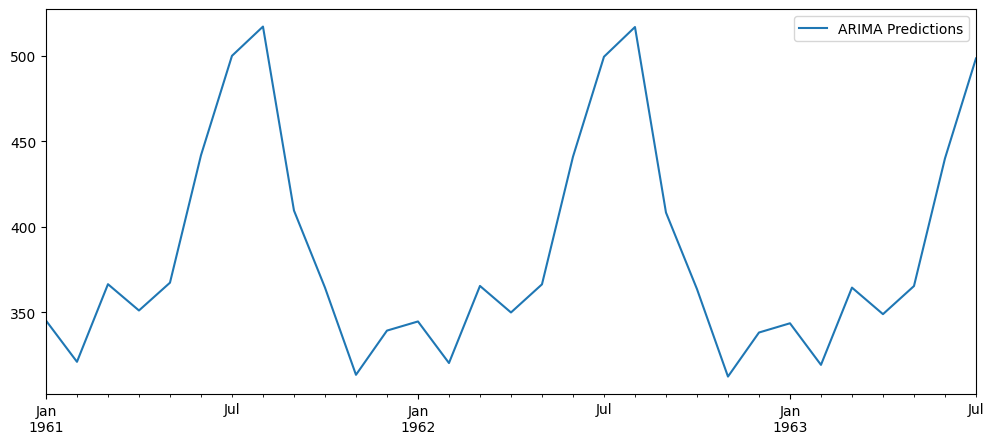

In [51]:
pred.plot(figsize=(12,5),legend=True)